# Guide Calling Using the Cellranger Module HDF5 File 
## Utilising Direct Capture Perturb-Seq to Deciphering Alternative Promoter Usage  

1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.

4. **Normalisation of adata object and E-distance of KD**
5. Check gene and neighboring gene expression
6. Create individual umaps per gene of interest 

    A. UMAPs 
    
    B. Rand Index score
7. Cell phase assignment model from FUCCI-matched single cell paper (GSE146773_)
8. Differential Expression analysis.

    A. Find the shared P1 and P2 genes. 

    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
    
9.  CNV Score & Numbat to quantify and Velocity quantification with loom file
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment



In [ ]:
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
import scperturb
from pyensembl import EnsemblRelease
from liftover import get_lifter
import os 

import sys
from apu_analysis import *
import scperturb
import infercnvpy as cnv
from apu_analysis.cell_import import CellPopulation
import matplotlib.pyplot as plt
# colours using garvan 
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'

#use viridis
color1="#fde725"
color2="#7ad151"
color3="#22a884"
color4="#2a788e"
color5="#2a788e"
color6='#440154'

#hotpink yellow and blue
color1='#d81b61' #true
color2='#fec111' #false
color3='#2179b4' #negative control

#protein level
color1='#3d82c4' #true
color2='#2179b4' #false

# Create the color palette
palette = sns.color_palette([color1, color2,color3])
new_palette = sns.color_palette([color1, color2,color1, color2,color1, color2,color1, color2,color1, color2,color1, color2, color3, color4])

loc=os.path.expanduser("~")
fig_loc=loc+"/figures/"

print("Scanpy", sc.__version__)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [40]:
##this reads in the output from 10x as well as cell_indetities.csv which is a file that annotates each cell barcode with a 
#cell_barcode,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells
pop = CellPopulation.from_file('alt-prom-crispr-fiveprime/cellranger_output',
                               genome='', filtered=True,raw_umi_threshold=100)
strip_low_expression(pop) 

#create list of nontargeting guides
nontargeting_control=[v for v in pop.cells["guide_identity"] if (str(v).startswith("Neg")|str(v).startswith("non")|str(v).startswith("Non")| str(v).startswith("sgNegC"))]
non_targeting_list=list(dict.fromkeys(nontargeting_control))

#add perturbation column to the pop.cells dataframe
pop.cells["perturbation"]=np.where(pop.cells["guide_identity"].isin(non_targeting_list),"non-targeting",pop.cells["guide_identity"].str.split("_").str.get(0).str.split("sg").str.get(1))

#seperately annotate the positive control guides
pos_control=[v for v in pop.cells["guide_identity"] if (str(v).startswith("sgRPL3")|str(v).startswith("sgSNRPD")|str(v).startswith("sgATF5")|str(v).startswith("sgGINS1")|str(v).startswith("sgRPL31A")|str(v).startswith("sgSNRPD"))]
pop.cells["perturbation"]=np.where(pop.cells["guide_identity"].isin(pos_control),pop.cells["perturbation"].str[:-1],pop.cells["perturbation"])

#add a column for the promoter type
pop.cells["promoter_type"]=pop.cells["guide_identity"].str.split("_").str.get(1).str[:2]
pop.cells["promoter_type"][(pop.cells["promoter_type"]=="00") | (pop.cells["promoter_type"]=="01") | (pop.cells["promoter_type"]=="02") | (pop.cells["promoter_type"]=="03")] = "Control"
pop.cells=pop.cells.drop_duplicates()
#add certain filters and add information
pop.cells=add_filter_columns(input_dataframe=pop.cells)
print(pop.cells.shape, pop.cells["cell_barcode"].nunique())

Loading digital expression data: alt-prom-crispr-fiveprime/cellranger_output/filtered_feature_bc_matrix/matrix.mtx...
Densifying matrix...
Loading guide identities:alt-prom-crispr-fiveprime/cellranger_output/cell_identities.csv...
Generating summary statistics...
Done.
(28365, 25) 28365


In [ ]:
%%capture
adata = ad.read_h5ad(loc+"files/adata_normalised.h5ad")
adata.X=adata.layers["log1p"]

In [64]:
if 'processed' in adata.uns.keys():
    print('The dataset is already processed. Skipping processing...')
else:
  adata = ad.AnnData(pop.matrix.loc[pop.cells["cell_barcode"]])
  adata.obs = pop.cells
  adata.var_names = pop.matrix.columns
  adata.obs_names = adata.obs["cell_barcode"].values
  adata.X=adata.X.astype('float32')
  adata.var_names_make_unique()
  #remove any na values from 
  adata = adata[~(adata.obs["guide_id"].isna()),:]
  #remove all genes that start with sg 
  adata=adata[:,~((adata.var_names.str.startswith('sg'))|(adata.var_names.str.startswith('non'))|(adata.var_names.str.startswith('Non')))]
  whippet=pd.read_excel("/Supplementary_Information/Table_S4.xlsx")
  adata.obs['guide_target']=np.where(adata.obs['guide_target'].str.startswith("sg"),adata.obs['guide_target'].str[2:],"non-targeting")
  #merge on the lhs with whippet
  adata.obs=adata.obs.merge(whippet, left_on="guide_target",right_on="gene",how="left")
  adata.obs["successfulKD"]=adata.obs["successfulKD"].astype('str')
  adata.obs_names = adata.obs["cell_barcode"].values

  #import another
  adata2 = sc.read_10x_mtx("alt-prom-crispr-fiveprime/cellranger_output/filtered_feature_bc_matrix")
  #add pop2 to pop #get the same genes and cells as adata 
  #list of genes found in both 
  genes = list(set(adata.var_names) & set(adata2.var_names))
  #list of cells found in both
  cells = list(set(adata.obs_names) & set(adata2.obs_names))
  adata=adata[cells,genes]
  adata2=adata2[cells,genes]
  #add the X from adata2 to adata
  adata.X=adata.X + adata2.X
  adata.layers['counts'] = adata.X.copy()
  mitochondrial_genes=sc.queries.mitochondrial_genes("hsapiens",attrname="hgnc_symbol")
  adata.var['mt'] = adata.var_names.isin(mitochondrial_genes["hgnc_symbol"]) # annotate the group of mitochondrial genes as 'mt'
  sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

  # basic qc and pp
  sc.pp.filter_cells(adata, min_counts=1000)
  sc.pp.normalize_per_cell(adata)
  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.filter_genes(adata, min_cells=50)
  sc.pp.log1p(adata)
  #save the log1p normalised matrix
  adata.layers['log1p'] = adata.X.copy()

  adata = adata[adata.obs["pct_counts_mt"] < 10, adata.var['mt']==False] 
  sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

  # select HVGs
  n_var_max = 2000  # max total features to select

  sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
  sc.pp.pca(adata, use_highly_variable=True)
  sc.pp.neighbors(adata)
  adata.uns['processed'] = True
  adata.obs["good_coverage"]=adata.obs["good_coverage"].astype("category")
  adata.write_h5ad(loc+"files/adata_normalised.h5ad")

The dataset is already processed. Skipping processing...


In [65]:
adata.obs["log_guide_UMI_count"]=np.log1p(adata.obs["guide_UMI_count"])

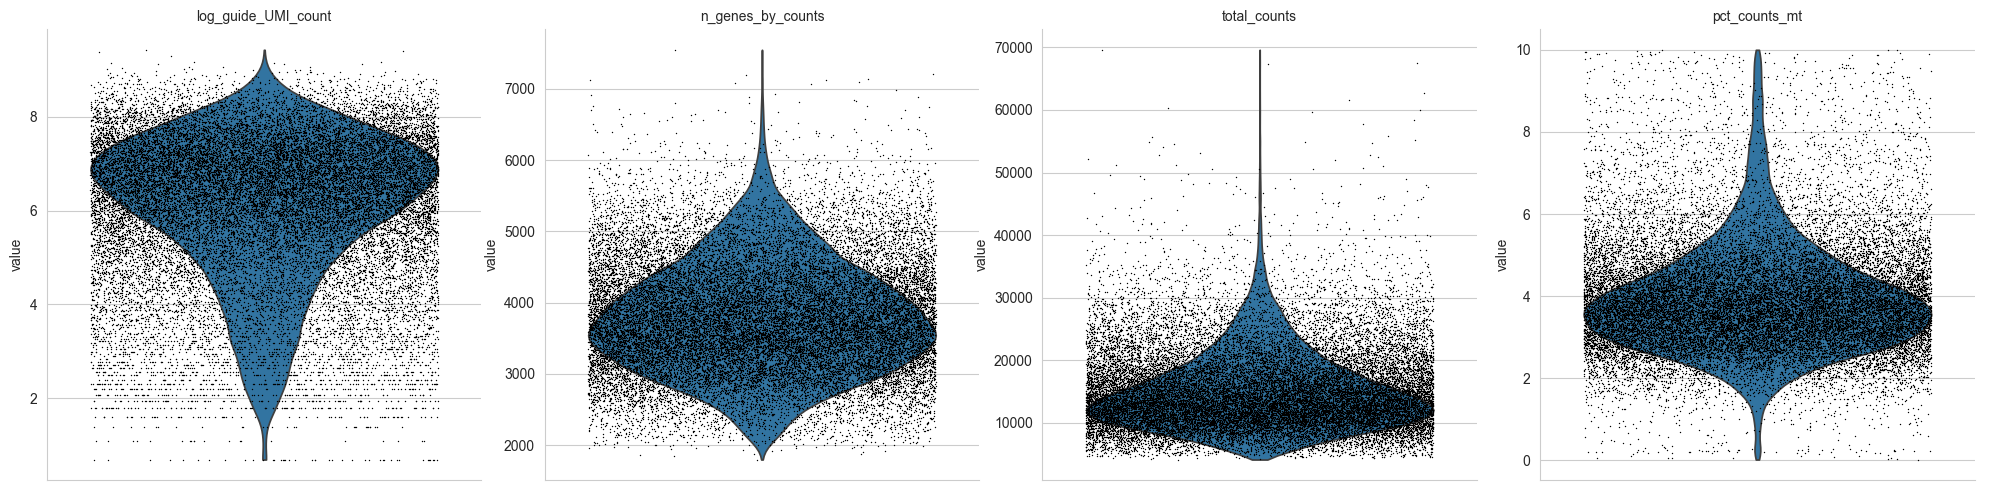

In [66]:
# adata.write_csvs(loc+'files/adata_normalised/')
sc.pl.violin(
    adata,
    ["log_guide_UMI_count","n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True, save = "qc.png"
)


<Axes: xlabel='highly_variable', ylabel='pct_dropout_by_counts'>

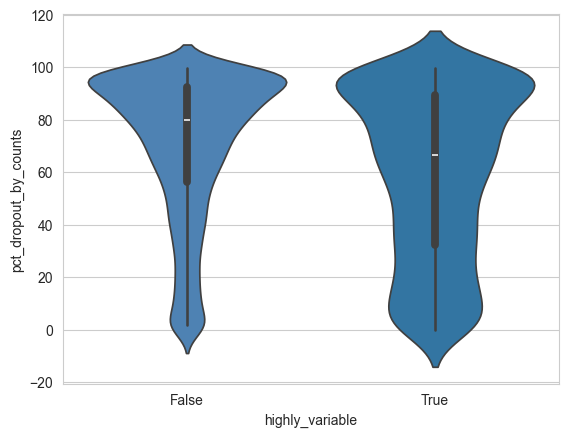

In [67]:
sns.violinplot(x="highly_variable", y="pct_dropout_by_counts", data=adata.var, palette=new_palette)

In [68]:
list_twoprom=adata.obs.groupby(["perturbation"])["promoter_type"].nunique() == 2
adata.obs["two"]=adata.obs["perturbation"].isin(list_twoprom[list_twoprom==True].index)
#apply the function to every gene that has both MP and AP promoter type
#create a column to chekc if both AP and MP 
perturb= adata.obs["perturbation"][(adata.obs["perturbation"]!="non-targeting") & (adata.obs["two"]==True)]
perturb=perturb.unique()
#choose the 
grouping_variable="guide_id"
negative_control="non-targeting_Control"


In [69]:

try:
    #read in the edistcsv
    df=pd.read_csv(loc+"files/edist_perprom.csv", index_col=0)
except:
    df_list=[test_edist_perprom(adata, gene, grouping_variable, negative_control) for gene in perturb]   
    #flatten the df_list 
    df=pd.concat(df_list)
    df.to_csv(loc+"files/edist_perprom.csv")

In [70]:
df = df[df["pvalue"]!=1]
df["gene"]=df.index.str.split("_").str.get(0)
df['neglog10_pvalue_adj'] = -np.log10(df['pvalue_adj'])
#import the gene to 5' UTR annotation file
nterm=pd.read_table(loc+"files/reference/all_pivot_simple_nterm.txt")
#color the violin plot above with the 5'UTR annotation
df=nterm.merge(df, left_on="Gene_symbol",right_on="gene",how="right").sort_values(by="edist")
df.index=df["gene"]
whippet=pd.read_excel("Supplementary_Information/Table_S4.xlsx")
df=df.merge(whippet,right_on="gene",left_index=True,how="right")

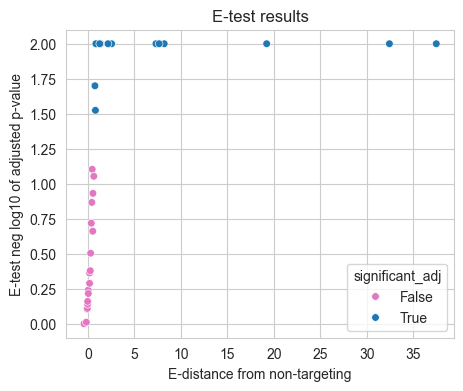

In [73]:

fig, ax = pl.subplots(1,1, figsize=[5,4])

scat=sns.scatterplot(data=df[df["successfulKD"]==True], y='neglog10_pvalue_adj', x='edist', hue='significant_adj', 
                     palette={True: 'tab:blue', False: 'tab:pink', 'Non-Targeting': 'tab:orange'}, s=30)
plt.title('E-test results')
plt.xlabel('E-distance from non-targeting')
plt.ylabel('E-test neg log10 of adjusted p-value')
scat.figure.savefig(fig_loc+"etest_pvalue_adj.pdf")

plt.show()

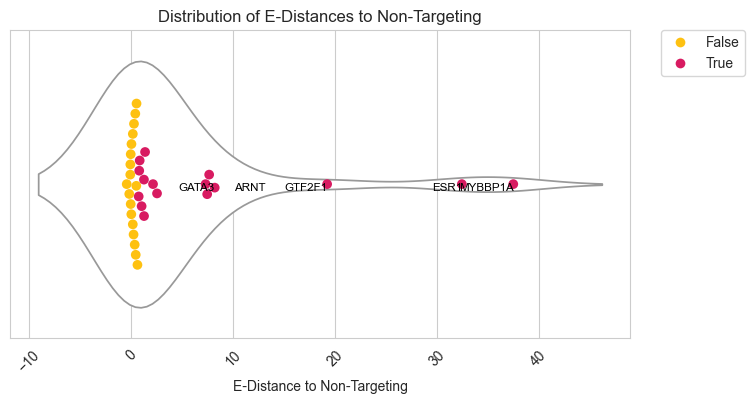

In [74]:
sns.set_style("whitegrid")
#put two colors d81b61 fec111
palette_new={True: "#d81b61", False: "#fec111"}
fig, ax1 = plt.subplots(1, 1, figsize=(8,4))
plt.setp(ax.collections, alpha=.8)
sns.violinplot(data=df[df["successfulKD"]==True], x='edist', inner=None,  color="white",  ax=ax1)
sns.swarmplot(data=df[df["successfulKD"]==True],   x='edist', size=7,ax=ax1,  hue='significant_adj',dodge=False,palette=palette_new)
#change it to jitter for labels
# for i in df[df["gene"].isin(["BRIP1","MYBBP1A","ESR1","PSMC5"])].sort_values("edist").tail(n=5).index:
#     ax1.text(df.loc[i,"edist"]+0.01, 0.02,df.loc[i,"gene"], horizontalalignment='right', size='small', color='black')

for i in df[df["significant_adj"]==True].sort_values("edist").tail(n=5).index:
    ax1.text(df.loc[i,"edist"]+0.01, 0.02,df.loc[i,"gene"], horizontalalignment='right', size='small', color='black')
plt.xticks(rotation=45)
plt.yticks([0], [''])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#label esr1
plt.xlabel('E-Distance to Non-Targeting')
plt.title('Distribution of E-Distances to Non-Targeting')

sns.set_style("whitegrid")

fig.figure.savefig(fig_loc+"edistance_violinplot.pdf")
plt.show()

In [76]:
df.to_csv(loc+"files/edist_results.csv")
#extract the significant genes above 
significant_genes=df[df["significant_adj"]==True].sort_values("edist")
significant_genes.to_csv(loc+"files/significant_genes.csv")

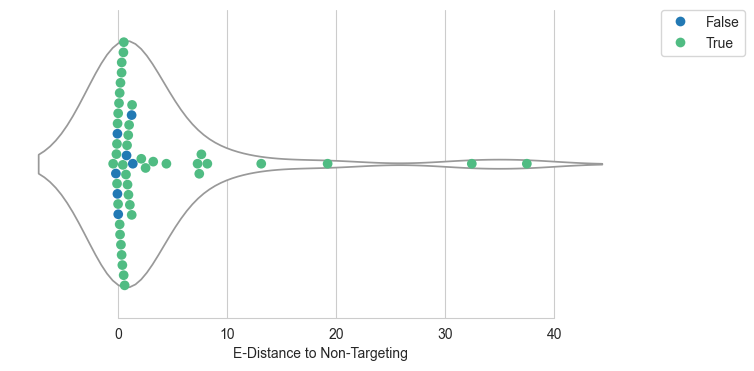

In [77]:
sns.set_style("whitegrid")
#change palette_two 5UTR #2279b4 Nterminus #50bc83
palette_two={False: "#2279b4", True: "#50bc83"}
fig, ax1 = plt.subplots(1, 1, figsize=(8,4))
plt.setp(ax.collections, alpha=.3)
sns.violinplot(data=df, x='edist', inner=None, color="white",  ax=ax1)
sns.despine(trim=True, left=True)
sns.swarmplot(data=df,  x='edist', size=7,ax=ax1,  hue='Nterminus_Change',dodge=False,palette=palette_two)

plt.yticks([0], [''])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.xlabel('E-Distance to Non-Targeting')
fig.figure.savefig(fig_loc+"edistance_violinplot_utr.pdf")





In [202]:
#choose the 
grouping_variable="guide_id"
negative_control="non-targeting_Control"

# grouping_variable="guide_assignment"
# negative_control="non-targeting"
adata_sgRNA=adata
adata_sgRNA.obs["guide_assignment"]=np.where(adata_sgRNA.obs["guide_target"]=="non-targeting","non-targeting",adata_sgRNA.obs["guide_assignment"])
data_sgRNA = scperturb.equal_subsampling(adata_sgRNA, grouping_variable, N_min=80)
sc.pp.filter_genes(data_sgRNA, min_cells=3)  # sanity cleaning

# select HVGs
n_var_max = 2000  # max total features to select
sc.pp.highly_variable_genes(data_sgRNA, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
sc.pp.pca(data_sgRNA, use_highly_variable=True)
sc.pp.neighbors(data_sgRNA)

In [103]:
estats = scperturb.edist(adata_sgRNA,obs_key=grouping_variable, obsm_key='X_pca', dist='sqeuclidean')


100%|██████████| 5886/5886 [00:18<00:00, 322.32it/s]


In [104]:
df = scperturb.etest(adata_sgRNA, obs_key=grouping_variable, obsm_key='X_pca', dist='sqeuclidean', control=negative_control, alpha=0.05, runs=400, n_jobs=-1)

100%|██████████| 400/400 [08:42<00:00,  1.31s/it]


In [99]:
#filter df
df.to_csv(loc+"/files/singlecell_shortread_analysis/edistance_full.csv")
#save two versions one per guide and one per perturbation
df = pd.read_csv(loc+"/files/singlecell_shortread_analysis/edistance_full.csv")

[Text(0.5, -26.570000000000004, ''), Text(-13.25, 0.5, '')]

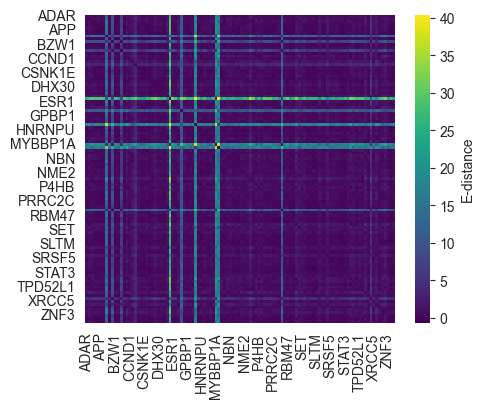

In [92]:
index=tuple(zip(estats.index.str.split('_').str[0].to_list(),estats.index.str.split('_').str[1].to_list()))
columns=tuple(zip(estats.columns.str.split('_').str[0].to_list(),estats.columns.str.split('_').str[1].to_list()))
estats.index = pd.MultiIndex.from_tuples(index) 
estats.columns = pd.MultiIndex.from_tuples(columns) 
fig, ax = pl.subplots(1,1, figsize=[5,4])
order = estats.sort_index().index
order_estats=estats.loc[order, order]
order_estats.index = order_estats.index.droplevel(1)
order_estats.columns = order_estats.columns.droplevel(1)

sns_plot = sns.heatmap(order_estats, cmap='viridis', ax=ax, cbar_kws={'label': 'E-distance'})
#save to pdf
fig_loc="
sns_plot.figure.savefig(fig_loc+"edistance_heatmap.pdf")


ax.set(xlabel="", ylabel="")

In [ ]:
# df.loc[df.index=='non-targeting', 'significant_adj'] = 'non-targeting'
df['neglog10_pvalue_adj'] = -np.log10(df['pvalue_adj'])
df["significant_adj"][df.index==negative_control]="Non-Targeting"
#import the gene to 5' UTR annotation file
nterm=pd.read_table(loc+"files/reference/all_pivot_simple_nterm.txt")
#color the violin plot above with the 5'UTR annotation
df["Gene_symbol"]=df.index.str.split("_").str.get(0)
df["name"]=df.index
df=nterm.merge(df, on="Gene_symbol",how="right").sort_values(by="edist")
df.index=df["name"]

